In [1]:
import numpy as np
import sys
sys.path.append('/Users/dangoldberg/Desktop/code/tlrl')
sys.path.append('/Users/dangoldberg/Desktop/code/tlrl/lib')

In [2]:
from TrRBM_train_models import *

In [3]:
def train_transfer_mapping(source_env_str, target_env_str, option_str='random'):

    source_random_path = ENVS_PATH_DICTIONARY[source_env_str]['instances_path'] + option_str + '_instances.pkl'
    target_random_path = ENVS_PATH_DICTIONARY[target_env_str]['instances_path'] + option_str + '_instances.pkl'
    source_optimal_path = ENVS_PATH_DICTIONARY[source_env_str]['instances_path'] + 'optimal_instances.pkl'

    target_env = ENVS_PATH_DICTIONARY[target_env_str]['env']
    # load source task random samples
    source_action_encoder, source_random = unpack_samples(load_samples(source_random_path), OneHotEncoder(sparse=False))

    # load target task random samples
    target_action_encoder, target_random = unpack_samples(load_samples(target_random_path), OneHotEncoder(sparse=False))

    # prepare samples
    source_random, target_random = even_out_samplesizes(source_random, target_random)
    source_scaler, source_random = utils.standardize_samples(source_random)
    target_scaler, target_random = utils.standardize_samples(target_random)

    # load the TrRBM model

    rbm = trrbm.RBM(
        name="TrRBM",
        v1_size=source_random.shape[1],
        h_size=params_dictionary["TrRBM_hidden_units"],
        v2_size=target_random.shape[1],
        n_data=source_random.shape[0],
        batch_size=params_dictionary["TrRBM_batch_size"],
        learning_rate=params_dictionary["TrRBM_learning_rate"],
        num_epochs=params_dictionary["TrRBM_num_epochs"],
        n_factors=params_dictionary["TrRBM_n_factors"],
        k=params_dictionary["TrRBM_k"],
        use_tqdm=params_dictionary["TrRBM_use_tqdm"],
        show_err_plt=params_dictionary["TrRBM_show_err_plt"]
    )

    # train the TrRBM model
    errs = rbm.train(source_random, target_random)
    
    return rbm, errs, source_action_encoder, target_action_encoder, source_scaler, target_scaler

In [4]:
rbm, errs, source_action_encoder, target_action_encoder, source_scaler, target_scaler = train_transfer_mapping('2DMountainCar', '3DMountainCar', option_str='random')

squared reconstruction average batch error: 228.61272578125:   1%|▏         | 2/150 [00:02<03:03,  1.24s/it]//anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
squared reconstruction average batch error: 27.892380029296874: 100%|██████████| 150/150 [02:57<00:00,  1.17s/it]


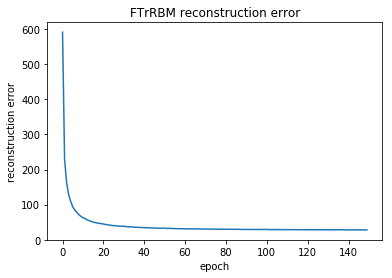

In [5]:
from matplotlib import pyplot as plt
import numpy as np

plt.plot(range(len(errs)),errs)
plt.title('FTrRBM reconstruction error')
plt.xlabel('epoch')
plt.ylabel('reconstruction error')
plt.show()

In [6]:
def get_source_instances(source_env_str, target_env_str, option_str='random'):

    source_random_path = ENVS_PATH_DICTIONARY[source_env_str]['instances_path'] + option_str + '_instances.pkl'
    target_random_path = ENVS_PATH_DICTIONARY[target_env_str]['instances_path'] + option_str + '_instances.pkl'
    source_optimal_path = ENVS_PATH_DICTIONARY[source_env_str]['instances_path'] + 'optimal_instances.pkl'
    source_realistic_path = ENVS_PATH_DICTIONARY[source_env_str]['instances_path'] + 'realistic_instances.pkl'
    
    target_env = ENVS_PATH_DICTIONARY[target_env_str]['env']
    # load source task random samples
    source_action_encoder, source_random = unpack_samples(load_samples(source_random_path), OneHotEncoder(sparse=False))

    # load target task random samples
    target_action_encoder, target_random = unpack_samples(load_samples(target_random_path), OneHotEncoder(sparse=False))

    # prepare samples
    source_random, target_random = even_out_samplesizes(source_random, target_random)
    source_scaler, source_random = utils.standardize_samples(source_random)
    target_scaler, target_random = utils.standardize_samples(target_random)
    
    source_optimal = unpack_episodes(load_samples(source_optimal_path), source_action_encoder, fit_encoder=False)
    source_scaled = source_scaler.transform(source_optimal)
    
    source_realistic = unpack_episodes([load_samples(source_realistic_path)], source_action_encoder, fit_encoder=False)
    
    return source_optimal, source_realistic

source_optimal, source_realistic = get_source_instances('2DMountainCar', '3DMountainCar', option_str='random')

In [7]:
#source_instances = source_optimal
source_instances = source_realistic

source_trajectory = source_instances



In [8]:
print(len(source_instances))

target_mapped = rbm.v2_predict(source_instances[:15000])
target_mapped = target_scaler.inverse_transform(target_mapped)

5000


In [9]:
mapped_trajectory = target_mapped

In [10]:
len(mapped_trajectory)

5000

In [11]:
import pickle
source_trajectory.dump('visualize_trajectories/2DMC-3DMC/source_trajectory.p')
mapped_trajectory.dump('visualize_trajectories/2DMC-3DMC/mapped_trajectory.p')

In [12]:
from envs import *

threeD = ENVS_DICTIONARY['3DMountainCar'](trailer=True, show_velo=True)
twoD = ENVS_DICTIONARY['2DMountainCar'](trailer=True)

In [13]:
source_trajectory = np.load('visualize_trajectories/2DMC-3DMC/source_trajectory.p')
mapped_trajectory = np.load('visualize_trajectories/2DMC-3DMC/mapped_trajectory.p')

In [14]:
for t in range(5000):
    
    twoD.state = source_trajectory[t]
    twoD.last_few_positions.append((source_trajectory[t][0]))
    if len(twoD.last_few_positions) == twoD.trail_num+1:
        del twoD.last_few_positions[0]
    twoD._render(action_vec=source_trajectory[t][4:])

    threeD.state = mapped_trajectory[t]
    threeD.last_few_positions.append((mapped_trajectory[t][0], mapped_trajectory[t][1]))
    if len(threeD.last_few_positions) == threeD.trail_num+1:
        del threeD.last_few_positions[0]
    threeD.render_orthographic(action_vec=mapped_trajectory[t][8:])
    
    
    
threeD.close()
twoD.close()